In [1]:
import os
import os.path
import glob
import pandas as pd
import numpy as np
from PIL import Image
import preprocessing as proc
from pandas.api.types import CategoricalDtype
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

%matplotlib inline

plt.style.use('seaborn-ticks')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

pd.options.display.max_columns = 1000

DATA_PATH = '../datasets/'

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.simplefilter('ignore')

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Load data

In [2]:
df = proc.load_data("Slide24h_ecm.csv", data_path=DATA_PATH)
df.columns = [col.lower() for col in df.columns]
df = df.drop(df[df.label == 'H2'].index).reset_index(drop=True)
print(df.shape)
df.head()

(315, 13)


,slide,label,spot,n,col1,col3,col4,col5,col6,fibr,lam,vitr,trop
0,1,A1,3,22,250.0,0,0.0,0,0,0.0,0.0,0.0,0
1,1,A1,2,8,250.0,0,0.0,0,0,0.0,0.0,0.0,0
2,1,A1,1,15,250.0,0,0.0,0,0,0.0,0.0,0.0,0
3,1,A1,6,10,250.0,0,0.0,0,0,0.0,0.0,0.0,0
4,1,A1,5,16,250.0,0,0.0,0,0,0.0,0.0,0.0,0


In [3]:
ecm_cols = df.columns[4:]
ecm_cols

Index(['col1', 'col3', 'col4', 'col5', 'col6', 'fibr', 'lam', 'vitr', 'trop'], dtype='object')

## Create dataset with single proteins

In [4]:
single_protein = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1']
df_single = pd.DataFrame(columns = df.columns)
for label in single_protein:
    df_single = pd.concat([df_single, df[df.label==label]], axis=0)
df_single.n = pd.to_numeric(df_single.n)
df_single.head()

,slide,label,spot,n,col1,col3,col4,col5,col6,fibr,lam,vitr,trop
0,1,A1,3,22,250.0,0,0.0,0,0,0.0,0.0,0.0,0
1,1,A1,2,8,250.0,0,0.0,0,0,0.0,0.0,0.0,0
2,1,A1,1,15,250.0,0,0.0,0,0,0.0,0.0,0.0,0
3,1,A1,6,10,250.0,0,0.0,0,0,0.0,0.0,0.0,0
4,1,A1,5,16,250.0,0,0.0,0,0,0.0,0.0,0.0,0


![]('./ecm_array.png')

In [5]:
single_protein_dict = {'A1' : 'col1', 'B1' : 'col3', 'C1' : 'col4', 
                       'D1' : 'col5', 'E1' : 'col6', 'F1' : 'fibr', 
                       'G1' : 'lam', 'H1' : 'vitr', 'I1' : 'trop'}

# Single proteins

In [6]:
df_single.groupby('label').n.mean()

label
A1    17.000000
B1     0.000000
C1     0.000000
D1     0.000000
E1    16.444444
F1    19.888889
G1     1.666667
H1    12.555556
I1     2.666667
Name: n, dtype: float64

In [102]:
single_protein_dict['B1'], single_protein_dict['C1'], single_protein_dict['D1']

('col3', 'col4', 'col5')

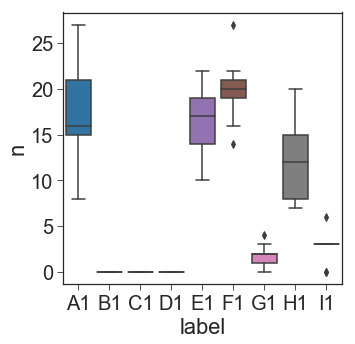

In [7]:
plt.rcParams['figure.figsize'] = (5, 5)

sns.boxplot(x='label', y='n', data=df_single);

In [8]:
df_single.groupby('label').n.unique()

label
A1    [22, 8, 15, 10, 16, 27, 18, 21]
B1                                [0]
C1                                [0]
D1                                [0]
E1       [14, 16, 10, 19, 12, 17, 22]
F1       [20, 22, 27, 21, 14, 16, 19]
G1                    [4, 1, 2, 3, 0]
H1         [17, 8, 20, 7, 15, 12, 11]
I1                          [3, 6, 0]
Name: n, dtype: object

## Linear regression

In [91]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def train_test(X_train, y_train, X_test, y_test, model):
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)
    
    if model=='linreg':
        model = LinearRegression(fit_intercept=False)
    elif model=='tree':
        model = DecisionTreeRegressor()
    elif model=='forest':
        model = RandomForestRegressor()
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred))
    print("Training RMSE:", rmse_train)

    print("Null RMSE:", np.sqrt(mean_squared_error(y_test, y_test.apply(lambda x: np.mean(y_train)))))

    y_pred = model.predict(X_test)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Testing RMSE:", rmse_test)

In [94]:
X_train = df_single[ecm_cols]
y_train = df_single.n
print(X_train.shape, y_train.shape)

indices = [ind for ind in df.index.tolist() if ind not in df_single.index.tolist()]

X_test = df.loc[indices, ecm_cols]
y_test = df.loc[indices, 'n']
print(X_test.shape, y_test.shape)

train_test(X_train, y_train, X_test, y_test, 'linreg')

(81, 9) (81,)
(234, 9) (234,)
Training RMSE: 2.9509013758580873
Null RMSE: 7.840025481749209
Testing RMSE: 6.514468086829575


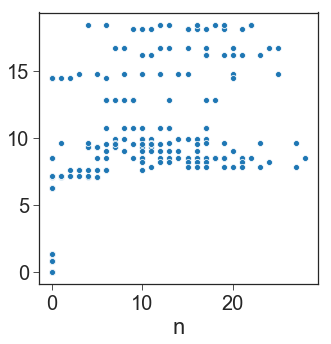

In [85]:
sns.scatterplot(y_test, y_pred);

In [104]:
tmp = df[(df.label == 'A1') | (df.label == 'A2') | (df.label == 'B2') | (df.label == 'C2')]

In [111]:
tmp[['col1']].corrwith(tmp.n)

col1    0.166002
dtype: float64

## Expore the data

In [ ]:
df.head()

In [18]:
df_single.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 0 to 224
Data columns (total 13 columns):
slide    81 non-null object
label    81 non-null object
spot     81 non-null object
n        81 non-null int64
col1     81 non-null float64
col3     81 non-null object
col4     81 non-null float64
col5     81 non-null object
col6     81 non-null object
fibr     81 non-null float64
lam      81 non-null float64
vitr     81 non-null float64
trop     81 non-null object
dtypes: float64(5), int64(1), object(7)
memory usage: 8.9+ KB


In [ ]:
df.label.value_counts()

In [ ]:
df.groupby('label').n.sum() == 0

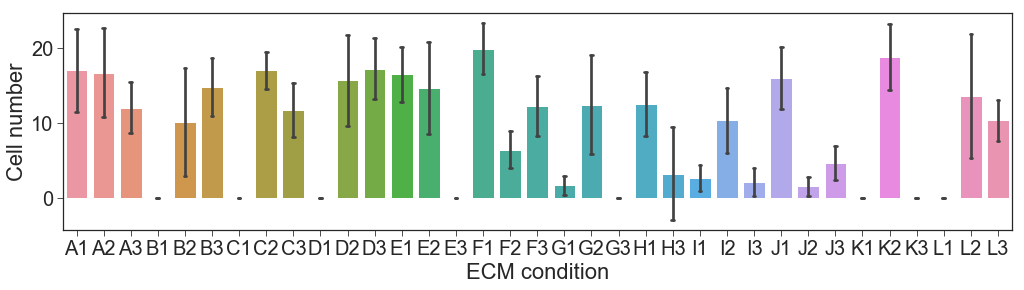

In [11]:
plt.rcParams['figure.figsize'] = (17, 4)

sns.barplot(x=df.label, y=df.n, ci='sd', capsize=.1);

plt.xlabel("ECM condition");
plt.ylabel("Cell number");
# plt.title("Numbers of attached cells")
plt.savefig('../results/Attached cells.png', bbox_inches='tight', dpi=300);

In [ ]:
df[df.label == "B1"]

In [ ]:
df[ecm_cols].hist(bins = 10,sharex=True, sharey=True, figsize = (12, 6));
plt.tight_layout()

In [ ]:
for label in pure:
    print(label, pure_dict[label], df[df.label==label].n.mean())

In [ ]:
p_corr = df24[ecm_cols].corrwith(df24.n)
p_corr

In [ ]:
sns.heatmap(pd.DataFrame(p_corr, columns=['Pearsons']).T, 
            cmap=sns.color_palette("RdBu_r", 10), 
            vmin=-0.5, vmax=0.5, 
            annot=True, annot_kws={"size": 22}, 
            yticklabels=False, cbar_kws={"aspect": 5});
plt.xticks(rotation=45);
plt.savefig('../results/ECM proteins corr.png', bbox_inches='tight', dpi=300);

In [ ]:
corr_matrix = df24.corr()
corr_matrix["N"].sort_values(ascending = False)

In [ ]:
df24.plot(kind = "scatter", x = "Fibr", y = "N", alpha = 0.5)

In [ ]:
df24.plot(kind = "scatter", x = "Col1", y = "N", alpha = 0.5)

In [ ]:
df24.plot(kind = "scatter", x = "Col6", y = "N", alpha = 0.5)

In [ ]:
df24.plot(kind = "scatter", x = "Col4", y = "N", alpha = 0.5)

In [ ]:
df24.plot(kind = "scatter", x = "Trop", y = "N", alpha = 0.5)

In [ ]:
df24_prod = df24.copy()
df24_prod["Col1_Col5"] = df24["Col1"] * df24["Col5"]
df24_prod.head()

In [ ]:
df24_prod.plot(kind = "scatter", x = "Col1_Col5", y = "N", alpha = 0.5)

## Convert into classification problem

In [ ]:
N = np.array(df24['N']).reshape(-1,1)

In [ ]:
plt.hist(N, bins=25)
plt.show()

In [ ]:
N = N.ravel()
np.min(N), np.percentile(N, 25), np.median(N), np.percentile(N, 75), np.max(N)

In [ ]:
N_positive = N[N>0]
print(np.min(N_positive), np.median(N_positive), np.max(N_positive))
p33 = np.percentile(N_positive, 33),
p66 = np.percentile(N_positive, 66),
p33, p66

In [ ]:
# Adhesion strength: 0 - no adhesion, 0<N<=p33 - low adhesion,
# p33<N<=p66 - moderate adhesion, p66<N<=max - high adhesion
adhesion_strength = np.zeros((len(N), 1), dtype = np.float32)
adhesion_strength[:,0][0 < N] = 1.0
adhesion_strength[:,0][p33 < N] = 2.0
adhesion_strength[:,0][p66 < N] = 3.0

In [ ]:
N[28], N[1], N[2], N[0]

In [ ]:
adhesion_strength[28], adhesion_strength[1], adhesion_strength[2], adhesion_strength[0]

In [ ]:
df24['Strength'] = adhesion_strength
df24.head()

## Create training and validation sets

In [ ]:
import random
from sklearn.utils import shuffle

def stratify(df, train_size=7):

    labels = df['Label'].unique()

    strat_train_set = pd.DataFrame()
    strat_val_set = pd.DataFrame()

    for i in range(0, len(labels)):
        shuffled_indices = np.random.permutation((range(0, 9)))
        train_indices = shuffled_indices[: train_size]
        val_indices = shuffled_indices[train_size :]
        strat_train_set = strat_train_set.append(df[df["Label"] == labels[i]].iloc[train_indices])
        strat_val_set = strat_val_set.append(df[df["Label"] == labels[i]].iloc[val_indices])
        
        strat_train_set = shuffle(strat_train_set)
    
    return strat_train_set, strat_val_set

In [ ]:
def create_train_val_sets(df, train_size=7, mode="regression"):
    strat_train_set, strat_val_set = stratify(df, train_size)
    X_train = strat_train_set.drop(["Slide", "Label", "Spot", "N", "Strength"], axis = 1).values
    X_val = strat_val_set.drop(["Slide", "Label", "Spot", "N", "Strength"], axis = 1).values
    if mode == "regression":
        y_train = strat_train_set["N"].values
        y_val = strat_val_set["N"].values
    if mode == "classification":
        y_train = strat_train_set["Strength"].values
        y_val = strat_val_set["Strength"].values
    print(len(X_train), len(X_val))
    return X_train, X_val, y_train, y_val

## Compare learning curves

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

def regression(model, X, y, train=True):
    if train:
        model.fit(X, y) 
    y_predict = model.predict(X)
    mse = mean_squared_error(y_predict, y)
    return mse

In [ ]:
def plot_learning_curves(reg_model, X_train, y_train, X_test, y_test, poly=True):
    #poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    std_scaler = StandardScaler()
    if (poly):
        poly_features = PolynomialFeatures(degree=2, include_bias=False)
        full_pipeline = Pipeline([
            ("poly_features", poly_features),
            ("std_scaler", std_scaler),
            ("lin_reg", reg_model)
        ])
    else:
        full_pipeline = Pipeline([
            ("std_scaler", std_scaler),
            ("lin_reg", reg_model)
        ])
    train_error, test_error = [], []

    for m in range (1, len(X_train) + 1):
        train_error.append(regression(full_pipeline, X_train[:m], y_train[:m]))
        test_error.append(regression(full_pipeline, X_test, y_test, train=False))
        
    print("Train set RMSE:", np.sqrt(train_error[-1]), "\tTest set RMSE:", np.sqrt(test_error[-1]))
    plt.plot(np.sqrt(train_error), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(test_error), "b--", linewidth=3, label="test")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14) 
    plt.axis([0, len(X_train), 0 , 20])   
    plt.show() 
    
    if (poly):
        return poly_features.get_feature_names()

In [ ]:
X_train, X_val, y_train, y_val = create_train_val_sets(df24, train_size=7, mode="regression")

### Linear regression

In [ ]:
lin_reg = LinearRegression(fit_intercept=False)
plot_learning_curves(lin_reg, X_train, y_train, X_val, y_val)

In [ ]:
lin_reg.intercept_, lin_reg.coef_

### Lasso regression

In [ ]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha = 1.1, fit_intercept=False)

In [ ]:
feature_names = plot_learning_curves(lasso_reg, X_train, y_train, X_val, y_val)

In [ ]:
print(lasso_reg.intercept_)
print(sum(lasso_reg.coef_!=0))
print(np.asarray(feature_names)[lasso_reg.coef_!=0])
lasso_reg.coef_[lasso_reg.coef_!=0]

### Restricted model  

In [ ]:
df24_ext = df24.copy()
df24_ext["Col1_Col5"] = df24["Col1"] * df24["Col5"]
df24_ext["Col4_x2"] = df24["Col4"]**2
df24_ext["Col4_Col6"] = df24["Col4"] * df24["Col6"]
df24_ext["Fibr_x2"] = df24["Fibr"]**2
df24_ext["Fibr_Vitr"] = df24["Fibr"] * df24["Vitr"]
df24_ext.head()

In [ ]:
features = ['Col1', 'Col6', 'Fibr', 'Col1_Col5','Col4_x2', 'Col4_Col6','Fibr_x2', 'Fibr_Vitr']
df24_res = df24_ext[df24_ext[features].any(axis=1)]
#df24_res = df24_ext.copy()
df24_res = df24_res.drop(['Col3', 'Col4', 'Col5', 'Lam', 'Vitr', 'Trop'], axis=1)
df24_res.head()

In [ ]:
X_train, X_val, y_train, y_val = create_train_val_sets(df24_res, train_size=7, mode="regression")

In [ ]:
lin_reg = LinearRegression(fit_intercept=False)
plot_learning_curves(lin_reg, X_train, y_train, X_val, y_val, poly=False)

In [ ]:
print(lin_reg.intercept_)
print(sum(lin_reg.coef_!=0))
lin_reg.coef_[lin_reg.coef_!=0]

In [ ]:
x0, x4, x5, x0_x3, x2_2, x2_x4, x5_2, x5_x7 = np.meshgrid(np.linspace(0, 250, 11).reshape(-1, 1),
                                                            np.linspace(0, 250, 11).reshape(-1, 1),
                                                            np.linspace(0, 250, 11).reshape(-1, 1),
                                                            np.linspace(0, 62500, 11).reshape(-1, 1),
                                                            np.linspace(0, 62500, 11).reshape(-1, 1),
                                                            np.linspace(0, 62500, 11).reshape(-1, 1),
                                                            np.linspace(0, 62500, 11).reshape(-1, 1),
                                                            np.linspace(0, 62500, 11).reshape(-1, 1),
                                           )
X_new = np.c_[x0.ravel(), x4.ravel(), x5.ravel(), 
              x0_x3.ravel(), x2_2.ravel(), x2_x4.ravel(), 
              x5_2.ravel(), x5_x7.ravel()]
x0.shape
#y_predict = lasso_reg.predict(X_new)

In [ ]:
zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

N ~ Col1 + Col6 + Fibr + Fibr^2;
N ~ Col1 + Col6 + Fibr + Col1Col3 - Col4^2 + Fibr^2 + FibrVitr

### Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=2, l1_ratio=0.5, fit_intercept=False)

In [ ]:
plot_learning_curves(elastic_net, X_train, y_train, X_test, y_test)

In [ ]:
print(elastic_net.intercept_)
elastic_net.coef_

## Plain polynomial regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X_train)
print(len(X_train[0]), len(X_poly[0]))
print(X_train[0])
print(X_poly[0])
print(poly_features.get_feature_names())

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_poly_std = std_scaler.fit_transform(X_poly)
X_poly_std[0]

In [ ]:
np.mean(X_poly[:,0])

In [ ]:
np.mean(X_poly_std[:,0])

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X_poly, y_train)
lin_reg.intercept_, lin_reg.coef_

In [ ]:
y_train_predict = lin_reg.predict(X_poly)
mse = mean_squared_error(y_train_predict, y_train)
np.sqrt(mse)

## One feature

In [ ]:
X_1f = strat_train_set["Fibr"].values.reshape(-1, 1)
y_1f = strat_train_set["N"].values
len(X_1f)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_1f_poly = poly_features.fit_transform(X_1f)
print(X_1f[:5])
print(X_1f_poly[:5])

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X_1f_poly, y_1f)
lin_reg.intercept_, lin_reg.coef_

In [ ]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(fit_intercept=False)
lasso_reg.fit(X_1f_poly, y_1f)
lasso_reg.intercept_, lasso_reg.coef_

In [ ]:
y_1f_predict = lin_reg.predict(X_1f_poly)
mse = mean_squared_error(y_1f_predict, y_1f)
np.sqrt(mse)

In [ ]:
X_new = np.linspace(0, 250, 250).reshape(250, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lasso_reg.predict(X_new_poly)

plt.plot(X_1f, y_1f, "g.", alpha=0.3)
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("Fibronectin", fontsize=18)
plt.ylabel("Number of cells", fontsize=18)
plt.legend(loc="upper left", fontsize=14)
#plt.axis([-3, 3, 0, 10])
plt.show()

One predictor

In [ ]:
X = df24_clf.values[:, 9] # concentration of Fibronectin
y = df24_clf['Strength'] # adhesion strength

In [ ]:
X_ = np.c_[X, X**2]
y_ = y

In [ ]:
X_ = X[np.any(X>0, axis=1)]
y_ = y[np.any(X>0, axis=1)]

In [ ]:
plt.plot(X_[:, 0][y_==3], X_[:, 1][y_==3], "g^", label="high adhesion")
plt.plot(X_[:, 0][y_==2], X_[:, 1][y_==2], "bs", label="medium adhesion")
plt.plot(X_[:, 0][y_==1], X_[:, 1][y_==1], "yo", label="low adhesion")
#plt.plot(X_[:, 0][y_==0], X_[:, 1][y_==0], "r*", label="no adhesion")
plt.xlabel("Fibronectin", fontsize=14)
plt.ylabel("$Fibronectin^2$", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-5, 255, -5, 65000])
plt.show()

## Softmax regression

In [ ]:
strat_train_set, strat_test_set = stratify(df24, train_size=7)

In [ ]:
X_train = strat_train_set.drop(["Slide", "Label", "Spot", "N", "Strength"], axis = 1).values
y_train = strat_train_set["Strength"].values
X_test = strat_test_set.drop(["Slide", "Label", "Spot", "N", "Strength"], axis = 1).values
y_test = strat_test_set["Strength"].values
len(X_train), len(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

softmax_reg = LogisticRegression(multi_class="multinomial", fit_intercept=False, 
                                 solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X_train, y_train)

In [ ]:
x0, x4, x5 = np.meshgrid(
        np.linspace(0, 250, 11).reshape(-1, 1),
        np.linspace(0, 250, 11).reshape(-1, 1),
        np.linspace(0, 250, 11).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x4.ravel(), x5.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

In [ ]:
sum(y_predict==3)

In [ ]:
zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

## SVM

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X_train, y_train)

In [ ]:
labels = df24['Label'].unique()
for label in labels:
    tmp = df24_class.loc[df24_class["Label"]==label, ["Strength"]]
    print('Label:', label, '\t', tmp.median())